In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../dataset/raw/retail_sales_nigeria.csv")
df.head()

,Customer_ID,Order_ID,Order_Date,State,Category,Sub_Category,Segment,Quantity,Sales,Discount,Cost,Profit,Profit_Margin
0,CUST-00921,ORD-0002924,2020-01-01,Oyo,Office Supplies,Binders,Home Office,3,68944.87,0.18,41036.33,27908.53,0.40
1,CUST-06429,ORD-0020532,2020-01-01,Abuja,Technology,Phones,Corporate,4,15854.83,0.19,10988.00,4866.84,0.31
2,CUST-04454,ORD-0014125,2020-01-01,Rivers,Office Supplies,Pens,Corporate,1,39307.93,0.10,26003.41,13304.52,0.34
3,CUST-04405,ORD-0013963,2020-01-01,Delta,Office Supplies,Paper,Corporate,3,166329.82,0.00,114303.59,52026.23,0.31
4,CUST-05579,ORD-0017799,2020-01-01,Kaduna,Furniture,Shelves,Consumer,5,110150.61,0.08,73984.84,36165.76,0.33


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25446 entries, 0 to 25445
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer_ID    25446 non-null  object 
 1   Order_ID       25446 non-null  object 
 2   Order_Date     25446 non-null  object 
 3   State          25446 non-null  object 
 4   Category       25446 non-null  object 
 5   Sub_Category   25446 non-null  object 
 6   Segment        25446 non-null  object 
 7   Quantity       25446 non-null  int64  
 8   Sales          25446 non-null  float64
 9   Discount       25446 non-null  float64
 10  Cost           25446 non-null  float64
 11  Profit         25446 non-null  float64
 12  Profit_Margin  25446 non-null  float64
dtypes: float64(5), int64(1), object(7)
memory usage: 2.5+ MB


In [4]:
df.isnull().sum()

Customer_ID      0
Order_ID         0
Order_Date       0
State            0
Category         0
Sub_Category     0
Segment          0
Quantity         0
Sales            0
Discount         0
Cost             0
Profit           0
Profit_Margin    0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
for col in df.columns:
    print(f'{col}:\n {df[col].unique()}\n')


Customer_ID:
 ['CUST-00921' 'CUST-06429' 'CUST-04454' ... 'CUST-03998' 'CUST-06561'
 'CUST-00453']

Order_ID:
 ['ORD-0002924' 'ORD-0020532' 'ORD-0014125' ... 'ORD-0023627' 'ORD-0008266'
 'ORD-0001472']

Order_Date:
 ['2020-01-01' '2020-01-02' '2020-01-03' ... '2024-12-29' '2024-12-30'
 '2024-12-31']

State:
 ['Oyo' 'Abuja' 'Rivers' 'Delta' 'Kaduna' 'Enugu' 'Kano' 'Anambra' 'Ogun'
 'Lagos']

Category:
 ['Office Supplies' 'Technology' 'Furniture']

Sub_Category:
 ['Binders' 'Phones' 'Pens' 'Paper' 'Shelves' 'Tables' 'Laptops'
 'Accessories' 'Chairs']

Segment:
 ['Home Office' 'Corporate' 'Consumer']

Quantity:
 [3 4 1 5 2 0]

Sales:
 [ 68944.87  15854.83  39307.93 ... 123253.28   5475.86 154364.02]

Discount:
 [0.18 0.19 0.1  0.   0.08 0.04 0.16 0.09 0.05 0.12 0.01 0.11 0.14 0.06
 0.15 0.02 0.13 0.03 0.2  0.17 0.07 0.31 0.32 0.24 0.3  0.28 0.33 0.34
 0.4  0.22 0.38 0.23 0.21 0.29 0.39 0.26 0.35 0.25 0.27 0.36 0.37]

Cost:
 [ 41036.33  10988.    26003.41 ...  83558.03   3958.53 105029.25]

In [7]:
def wrangle(filepath):
    # Load data file into a dataframe
    df = pd.read_csv(filepath)

    # Convert date column to datetime datatype
    df["Order_Date"] = pd.to_datetime(df["Order_Date"])

    # Extract Year, Quarter, and Month features from the date column
    df["Year"] = df["Order_Date"].dt.year
    df["Month"] = df["Order_Date"].dt.month
    df["Month_Name"] = df["Order_Date"].dt.month_name()
    df["Quarter"] = df["Order_Date"].dt.to_period("Q").astype(str)

    # Create Profit margin column
    df["Profit_Margin"] = (df["Profit"] / df["Sales"]).round(2)

    # Highlight COVID-19 era flag
    df["COVID_Period"] = np.where(
        (df["Order_Date"] >= "2020-04-01") & (df["Order_Date"] <= "2021-06-30"),
        1,
        0
    )

    # Get Revenue per order
    df["Revenue_per_Order"] = (df["Sales"] / df["Quantity"]).round(2)

    # Categorize Discount column
    df["Discount_Band"] = pd.cut(
        df["Discount"],
        bins=[-0.01, 0.05, 0.15, 0.30, 1.0],
        labels=["No/Low", "Moderate", "High", "Very High"]
    )

    # Categorize Profit_Margin
    df["Margin_Category"] = pd.cut(
        df["Profit_Margin"],
        bins=[-1, 0.10, 0.25, 1],
        labels=["Low", "Medium", "High"]
    )
    
    # Create Order Count column
    df["Order_Count"] = (
        df.groupby("Customer_ID")["Order_ID"]
          .transform("nunique")
    )

    # Create Customer segments
    bins = [0, 1, 3, 6, float("inf")]
    labels = ["One-Time", "Occasional", "Regular", "Loyal"]
    df["Customer_Segment"] = pd.cut(df["Order_Count"], bins=bins, labels=labels)
    

    return df

In [8]:
df = wrangle("../dataset/raw/retail_sales_nigeria.csv")
df.head()

,Customer_ID,Order_ID,Order_Date,State,Category,Sub_Category,Segment,Quantity,Sales,Discount,...,Year,Month,Month_Name,Quarter,COVID_Period,Revenue_per_Order,Discount_Band,Margin_Category,Order_Count,Customer_Segment
0,CUST-00921,ORD-0002924,2020-01-01,Oyo,Office Supplies,Binders,Home Office,3,68944.87,0.18,...,2020,1,January,2020Q1,0,22981.62,High,High,6,Regular
1,CUST-06429,ORD-0020532,2020-01-01,Abuja,Technology,Phones,Corporate,4,15854.83,0.19,...,2020,1,January,2020Q1,0,3963.71,High,High,1,One-Time
2,CUST-04454,ORD-0014125,2020-01-01,Rivers,Office Supplies,Pens,Corporate,1,39307.93,0.10,...,2020,1,January,2020Q1,0,39307.93,Moderate,High,5,Regular
3,CUST-04405,ORD-0013963,2020-01-01,Delta,Office Supplies,Paper,Corporate,3,166329.82,0.00,...,2020,1,January,2020Q1,0,55443.27,No/Low,High,12,Loyal
4,CUST-05579,ORD-0017799,2020-01-01,Kaduna,Furniture,Shelves,Consumer,5,110150.61,0.08,...,2020,1,January,2020Q1,0,22030.12,Moderate,High,13,Loyal


In [9]:
# Save engineered dataframe as a csv file
df.to_csv("../dataset/engineered/retail_sales_nigeria_eng.csv", index=False)

### EDA

#### Seasonality Analysis

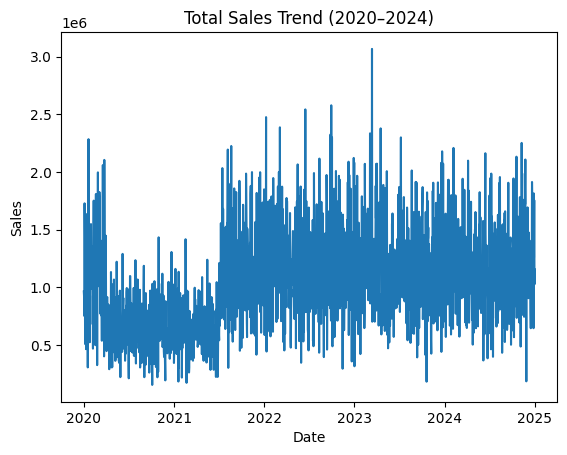

In [10]:
sales_trend = (
    df.groupby("Order_Date")["Sales"]
      .sum()
      .reset_index()
)

plt.figure()
plt.plot(sales_trend["Order_Date"], sales_trend["Sales"])
plt.title("Total Sales Trend (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


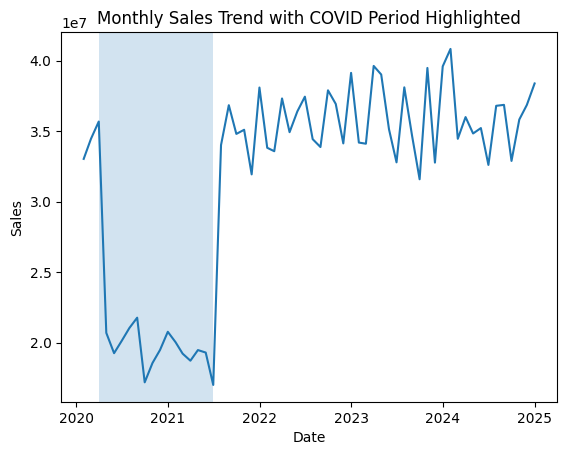

In [11]:
monthly_sales = (
    df.groupby(pd.Grouper(key="Order_Date", freq="ME"))["Sales"]
      .sum()
      .reset_index()
)

plt.figure()
plt.plot(monthly_sales["Order_Date"], monthly_sales["Sales"])
plt.axvspan(
    pd.to_datetime("2020-04-01"),
    pd.to_datetime("2021-06-30"),
    alpha=0.2
)
plt.title("Monthly Sales Trend with COVID Period Highlighted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


#### Product and Category PErformance

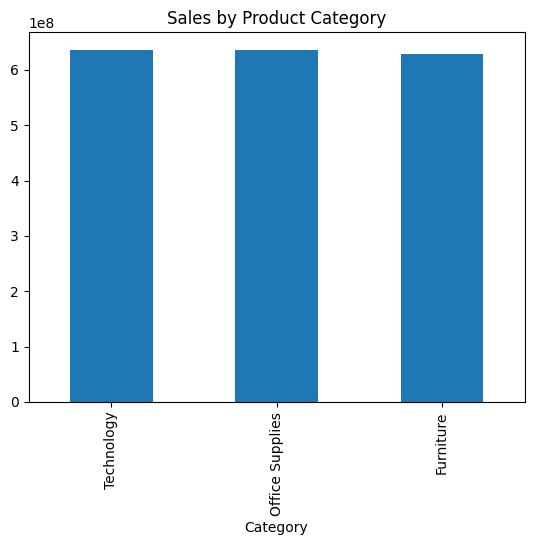

In [12]:
category_sales = (
    df.groupby("Category")["Sales"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
category_sales.plot(kind="bar")
plt.title("Sales by Product Category")
plt.show()


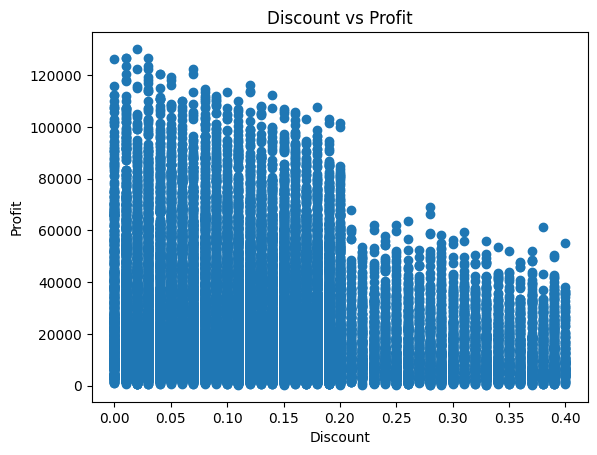

In [13]:
plt.figure()
plt.scatter(df["Discount"], df["Profit"])
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.title("Discount vs Profit")
plt.show()


#### Customer Behaviour

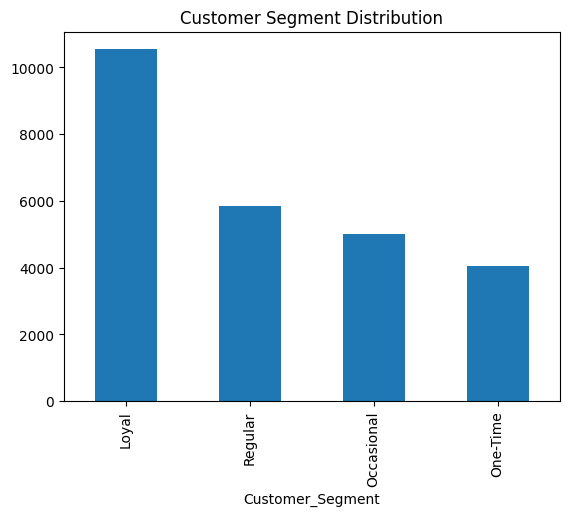

In [14]:
segment_counts = df["Customer_Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer Segment Distribution")
plt.show()


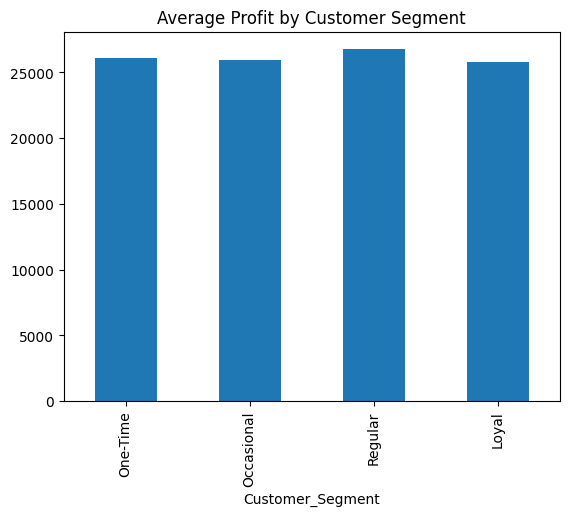

In [15]:
segment_profit = (
    df.groupby("Customer_Segment", observed=False)["Profit"]
      .mean()
)

plt.figure()
segment_profit.plot(kind="bar")
plt.title("Average Profit by Customer Segment")
plt.show()


#### COVID-19 impact Analysis

In [16]:
covid_comparison = (
    df.groupby("COVID_Period")[["Sales", "Profit"]]
      .mean()
)

covid_comparison.round(2)


,Sales,Profit
COVID_Period,,
0,84071.90,29412.49
1,46217.46,16162.07
